In [1]:
# Importing (using/include) packages and files needed for the code to run
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
using Dates
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")
include("GridOperations.jl")

# Note: that we import pyplot last to avoid a name conflict with grid
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

In [2]:
function initial_ice_depth(x::Float64,ice_thickness::Float64,wavelength::Float64,amplitude::Float64,initial_surface_depth::Float64)
    return ice_thickness + initial_surface_depth + amplitude*sin( 2pi/wavelength*x )
end

function ice_viscosity(T::Float64)
    Q = 40000.0 # Activation Enegry (J/mol)
    R_cont = 8.314 # Gas Constant (J/molK)
    ice_vis = (1e15)*exp((Q*(273.0-T))/(R_cont*(273.0*T)))
    upperlimit = 1e25
    lowerlimit = 1e12
    if ice_vis < lowerlimit
        ice_vis = lowerlimit
    elseif ice_vis > upperlimit
        ice_vis = upperlimit
    else 
        ice_vis = ice_vis
    end 
    return ice_vis
end

ice_viscosity (generic function with 1 method)

In [3]:
struct Materials
    # 1 - subsurface global ocean
    # 2 - icy shell
    # 3 - sticky air
    alpha::Vector{Float64} # Thermal expansion (1/K)
    rho0::Vector{Float64} # Density (kg/m^3)
    Hr::Vector{Float64} # Radiogenic heat production (W/m^3)
    Cp::Vector{Float64} # Heat capacity (J/kg*K)
    kThermal::Vector{Float64} # Thermal conductivity (W/m*K)
    eta::Vector{Float64} # Viscosity (Pa*s)
    function Materials()
        new([0.0,0.0,0.0],[1000.0,920.0,1.0],[0.0,0.0,0.0],[4180.0,2100.0,1.0e6],[0.5610,2.1,0.024],[1e12,1e15,1e17])
    end    
end

function update_marker_prop!(markers::Markers,materials::Materials)
    eta = markers.scalarFields["eta"]
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        markers.scalars[rho,i] = materials.rho0[mmat[i]]
        if mmat[i] == 2
            markers.scalars[eta,i] = ice_viscosity(markers.scalars[T,i])
        end
    end
end

function update_marker_temp!(markers::Markers,materials::Materials)
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    for i in 1:markers.nmark
        if mmat[i] == 1 
            markers.scalars[T,i] = 273.0
        elseif mmat[i] == 3 
            markers.scalars[T,i] = 100.0
        end 
    end 
end 

function initial_conditions!(markers::Markers,materials::Materials,options::Dict)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    Cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    kThermal = markers.scalarFields["kThermal"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        hice = initial_ice_depth(mx,options["ice thickness"],options["wavelength"],options["amplitude"],options["surface depth"])
        hsurf = options["surface depth"]
        if my > hice
            # subsurface global ocean
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 273.0
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]        
            markers.scalars[Cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1] 
            markers.scalars[kThermal,i] = materials.kThermal[1]
        elseif my > hsurf
            # icy shell
            markers.integers[material,i] = 2
            markers.scalars[T,i] = 100.0+((273.0-100.0)/(hice-hsurf))*(my-hsurf)
            # markers.scalars[eta,i] = eta_i[i]
            markers.scalars[alpha,i] = materials.alpha[2]
            markers.scalars[Cp,i] = materials.Cp[2]
            markers.scalars[Hr,i] = materials.Hr[2]
            markers.scalars[kThermal,i] = materials.kThermal[2]
        else
            # sticky air
            markers.integers[material,i] = 3
            markers.scalars[T,i] = 100.0            
            markers.scalars[eta,i] = materials.eta[3]
            markers.scalars[alpha,i] = materials.alpha[3]  
            markers.scalars[Cp,i] = materials.Cp[3]
            markers.scalars[Hr,i] = materials.Hr[3]
            markers.scalars[kThermal,i] = materials.kThermal[3]
        end
    end 
    # end loop over markers
    update_marker_prop!(markers,materials)
end

function get_interface(grid::CartesianGrid,mat::Matrix{Float64},contour_value::Float64)
    # Finding interfaces 
    interface_position = zeros(Float64,grid.nx);
    for j in 2:grid.nx
        i = 2
        while i <= grid.ny
            if mat[i,j] == contour_value
                interface_position[j] = grid.yc[i]
                break
            elseif mat[i+1,j] < contour_value
                # interface is located within this cell.
                interface_position[j] = grid.yc[i] + (grid.yc[i+1]-grid.yc[i])/(mat[i+1,j]-mat[i,j])*(contour_value-mat[i,j])
                break
            end
            i = i+1
        end
    end
    return interface_position
end

get_interface (generic function with 1 method)

In [4]:
options = Dict()
options["wavelength"] = 1e4
options["ice thickness"] = 1e4
options["amplitude"] = 0.10*options["ice thickness"]
options["surface depth"] = options["amplitude"] 

function run(options::Dict)
    W = options["wavelength"]
    H = options["ice thickness"] + options["surface depth"] + options["amplitude"] + 1e4
    ny = 251
    nx = Int64(ceil(W/H*ny))
    gx = 0.0
    gy = 0.113

    # Tbctype = [-1,-1,1,1] #left, right, top, bottom
    Tbctype = [-1,-1,1,1]
    # Tbcval = [0.0,0.0,100.0,273.0] #left, right, top, bottom
    Tbcval = [0.0,0.0,100.0,273.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()

    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","T","rho","eta","Cp","Hr","kThermal"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials,options)

    local time_plot = []
    # local topography = []
    local amplitude = []
    
    ### Setting up agruments for interface function ###
    # initial 
    i_mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
    i_air_ice_interface = get_interface(grid,i_mat,2.5)
    i_ocean_ice_interface = get_interface(grid,i_mat,1.5)
    Ai = options["amplitude"] 

    ### Setting up agruments for termination criteria ###
    max_step::Int64=-1
    max_time::Float64=-1.0
    max_time = max_time == -1.0 ? typemax(Float64) : max_time
    max_step = max_step == -1 ? typemax(Int64) : max_step
    
    time = 0.0
    iout= 0
    last_plot = 0.0
    dt = 1e10

    rho_c = nothing
    rho_vx = nothing 
    rho_vy = nothing 
    alpha = nothing 
    Hr = nothing 
    Cp_c = nothing 
    eta_s = nothing 
    eta_n = nothing 
    vxc = nothing 
    vyc = nothing 
    T = nothing 
    dTmax = nothing 
    dTemp = nothing 
    Tnew = nothing 
    Tlast = nothing 
    x_time = nothing
    kThermal = nothing
    # ocean_ice_interface = nothing
    mat = nothing

    itime = 1
    output_dir = "test"

    terminate = false
    while !terminate
        # 0. update the markers properties  
        update_marker_prop!(markers,materials)
        update_marker_temp!(markers,materials)
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_stag(markers,grid,["eta",],"basic")
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new,kThermal_new = marker_to_stag(markers,grid,["rho","Cp","alpha","eta","T","Hr","kThermal"],"center")
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy") 

        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
            replace_nan!(kThermal,kThermal_new)
        end
        # Copy field data 
        kThermal = copy(kThermal_new)
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)

        if itime == 1 
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
            cell_center_to_markers!(markers,grid,Tlast,markers.scalars[[markers.scalarFields["T"],],:])
        else
            ghost_temperature_center(grid,Tlast,Tbctype,Tbcval)
        end

        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy;dt=dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)

        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)*0.0
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)*0.0
        H = (adiabatic_heating .+ shear_heating .+ Hr).*0.0

        # 3. Compute the advection timestep
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc;dtmax=this_dtmax,cfl=0.25)
        diffusion_timestep = (grid.x[2]-grid.x[1])^2 / 1e-6
        if dt > diffusion_timestep
            dt = diffusion_timestep
        end

        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer = 1
        for titer=1:2
            # assemble and solve the energy equation
            # println("Trying with timestep ",dt/seconds_in_year/1e3," kyr")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbctype,Tbcval)
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbctype,Tbcval)
            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            # println("dTmax=",dTmax," dt=",dt/seconds_in_year/1e3," kyr")
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        ocean_ice_interface = get_interface(grid,mat,1.5)
        air_ice_interface = get_interface(grid,mat,2.5)
        max_ice_shell_thickness = maximum(ocean_ice_interface)-maximum(air_ice_interface)
        avg_ice_shell_thickness = mean(ocean_ice_interface)-mean(air_ice_interface)
        Af = max_ice_shell_thickness-avg_ice_shell_thickness
        # Checking Termination Criteria, time is in Myr
        if time >= max_time || itime >= max_step || Af/Ai <= 1/exp(1)
            terminate = true
        end     

        # println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))            
        # Moving the markers and advancing to the next timestep
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        itime += 1
        println("Finished Step ",itime," time=",time/seconds_in_year/1e3," kyr")
        mat, = marker_to_stag(markers,grid,markers.integers[[markers.integerFields["material"]],:],"center")
        ocean_ice_interface = get_interface(grid,mat,1.5)
        air_ice_interface = get_interface(grid,mat,2.5)
        append!(time_plot,time)
        # append!(topography,[ocean_ice_interface])
        append!(amplitude,Af)
    end
    return grid,i_mat,mat,time_plot,topography,time,itime
end

grid,i_mat,mat,times,topography,time,itime = run(options)

air_ice_interface = get_interface(grid,mat,2.5)
ocean_ice_interface = get_interface(grid,mat,1.5)
i_air_ice_interface = get_interface(grid,i_mat,2.5)
i_ocean_ice_interface = get_interface(grid,i_mat,1.5)

Creating Markers...
  0.070889 seconds (19 allocations: 105.676 MiB, 59.46% gc time)
Initial condition...
  0.783556 seconds (9.31 M allocations: 145.715 MiB, 3.51% gc time, 8.23% compilation time)
Finished Step 2 time=0.2442754058635868 kyr
Finished Step 3 time=0.4885508117271736 kyr
Finished Step 4 time=0.7328262175907604 kyr
Finished Step 5 time=0.9771016234543471 kyr
Finished Step 6 time=1.221377029317934 kyr
Finished Step 7 time=1.465652435181521 kyr
Finished Step 8 time=1.709927841045108 kyr
Finished Step 9 time=1.9542032469086947 kyr
Finished Step 10 time=2.1984786527722817 kyr
Finished Step 11 time=2.4427540586358685 kyr
Finished Step 12 time=2.6870294644994557 kyr
Finished Step 13 time=2.9313048703630424 kyr
Finished Step 14 time=3.175580276226629 kyr
Finished Step 15 time=3.4198556820902164 kyr
Finished Step 16 time=3.664131087953803 kyr
Finished Step 17 time=3.90840649381739 kyr
Finished Step 18 time=4.152681899680977 kyr
Finished Step 19 time=4.396957305544563 kyr
Finished 

115-element Vector{Float64}:
     0.0
 11028.794317594511
 11085.265200089005
 11142.790863804865
 11187.320776305973
 11248.315018866719
 11289.617428197822
 11349.552721615953
 11400.91067944434
 11448.024534792494
 11505.55932704245
 11542.771701047104
 11599.021625043624
     ⋮
 10402.921893094757
 10459.372691360917
 10493.210167104415
 10550.384228440631
 10594.588456997833
 10649.049299099659
 10707.72807595156
 10750.72122087427
 10811.61947313613
 10860.89783536975
 10916.394631269784
 10966.216419539713

In [5]:
grid.nx

115

In [6]:
topography

223-element Vector{Any}:
 [0.0, 11032.670934803831, 11087.615027843758, 11146.628188180366, 11189.455352742254, 11250.126634732062, 11291.32007428386, 11350.322583154195, 11401.486649287333, 11447.829628528954  …  10492.646006514533, 10549.578273063555, 10592.396427031148, 10647.443663954218, 10704.60173302141, 10748.031202798444, 10808.58593641287, 10855.02511868394, 10913.039455284092, 10959.174012505666]
 [0.0, 11036.872985083493, 11089.945025543311, 11150.055906075944, 11191.630000231626, 11251.841209737564, 11293.054832695101, 11351.054816747852, 11402.006368078182, 11447.600811318163  …  10492.105445935262, 10548.809140180963, 10590.32677071694, 10645.816322260323, 10701.264968950929, 10745.388701348185, 10805.27200704854, 10850.092860249357, 10909.846084608092, 10951.690861260377]
 [0.0, 11041.41040205655, 11092.275423526467, 11153.01289861633, 11193.897536475577, 11253.44316740429, 11294.776983036267, 11351.739919616093, 11402.5065753203, 11447.344212238733  …  10491.5776103678

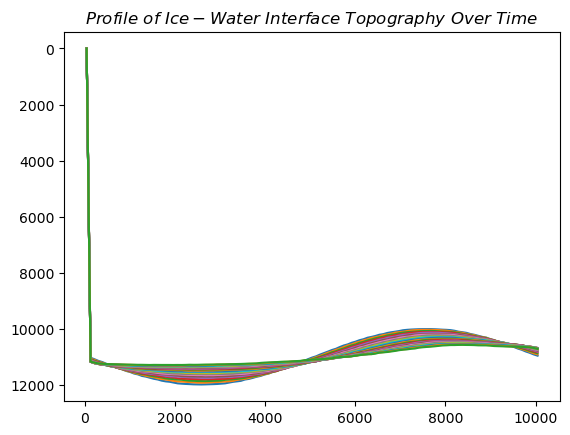

In [7]:
figure()
for i in 1:10:itime-1
    plot(grid.xc[2:end],topography[i])
end
title(L"Profile\,\,of\,\,Ice-Water\,\,Interface\,\,Topography\,\,Over\,\,Time")
gca().invert_yaxis()
show()

In [ ]:
figure()
for i in 1:itime-1
    plot(times[i],maximum(topography[i])-minimum(topography[i]),".")
end
#     gca().set_xlim([0.0,1e4]show()

In [ ]:
include("Topo.jl")

In [ ]:
max_ice_shell_thickness = maximum(ocean_ice_interface)-maximum(air_ice_interface)
avg_ice_shell_thickness = mean(ocean_ice_interface)-mean(air_ice_interface)
Af = max_ice_shell_thickness-avg_ice_shell_thickness

In [ ]:
tt = get_numerical_time_viscous(options["amplitude"],Af,last(times))

In [ ]:
ths = get_halfspace_time_viscous(options["wavelength"])

In [ ]:
tt/ths

In [ ]:
figure()
pcolor(grid.xc/1e3,grid.yc/1e3,i_mat)
plot(grid.xc[2:end-1]/1e3,i_air_ice_interface/1e3,"m",label="air-ice interface")
plot(grid.xc[2:end-1]/1e3,i_ocean_ice_interface/1e3,"r",label="air-ice interface")
title(L"Initial\,\,Model\,\,Schematic")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
legend(loc="upper center", bbox_to_anchor=(0.5,-0.15),fancybox="True",shadow="True",ncol=5)
show()

In [ ]:
figure()
pcolor(grid.xc/1e3,grid.yc/1e3,mat)
plot(grid.xc[2:end-1]/1e3,air_ice_interface/1e3,"m",label="air-ice interface")
plot(grid.xc[2:end-1]/1e3,ocean_ice_interface/1e3,"r",label="air-ice interface")
title(L"Final\,\,Model\,\,Schematic")
gca().invert_yaxis()
gca().set_aspect("equal")
gca().set_ylabel(L"Height\,(km)")
gca().set_xlabel(L"Width\,(km)")
legend(loc="upper center", bbox_to_anchor=(0.5,-0.15),fancybox="True",shadow="True",ncol=5)
show()